# Optimize Code Generation Workflow

In this example, we are building a workflow for code generation. The benchmark dataset used is [HumanEval](https://github.com/openai/human-eval).

The workflow is adopted from [Agents framework](https://github.com/aiwaves-cn/agents/tree/master/examples/humaneval), including two agents:
- **Draft agent**: completes the function body as an initial draft.
- **Refine agent**: checks and refines the funciton body.

> **Note**: function is not executed for the refine agent.

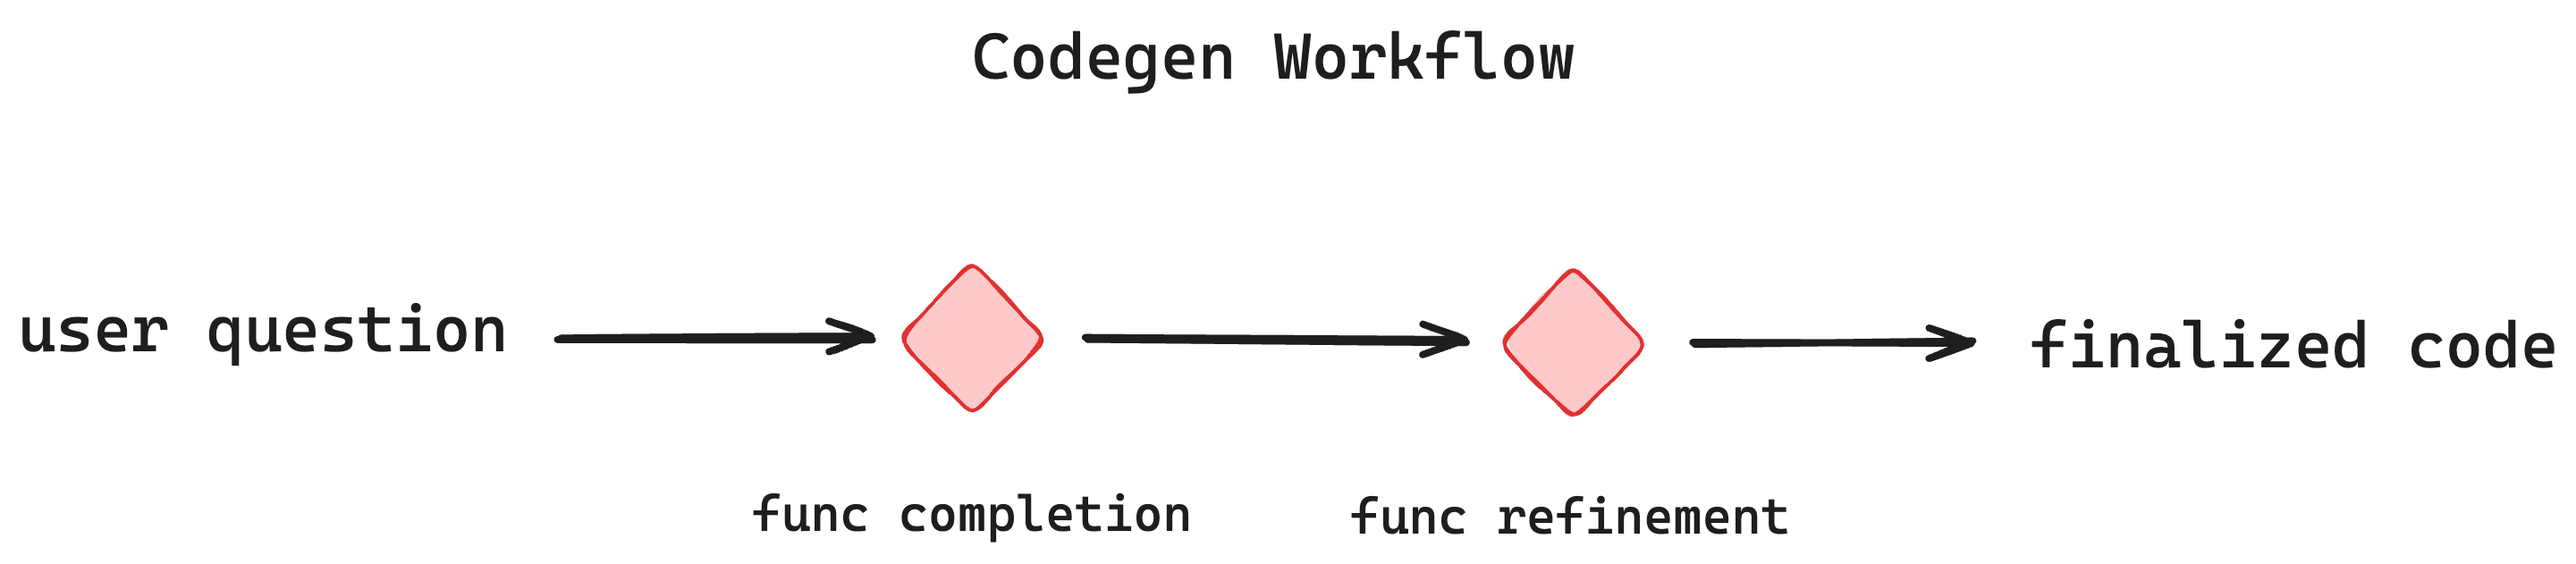

## 1) Setup

First, let's set the environment for workflow execution. We use openai model in this example, please set your key in `.env` file as:

OPENAI_API_KEY="your-openai-key"

## 2) Check Codegen Workflow

The implementation is based on `langchain` and is avaibale in `workflow.py`. Try it out with:

In [1]:
%run workflow.py

<result>
    balance = 0
    for char in brackets:
        if char == '(':
            balance += 1
        elif char == ')':
            balance -= 1
        if balance < 0:
            return False
    return balance == 0
</result>


## 3) Optimize The Workflow

The workflow entry point is already registered using annotation `cognify.register_workflow`.

Here we configure the optimization pipeline:
1. Define the evaluation method
2. Define the data loader
3. Config the optimizer

### 3.1 Tell Cognify how to evaluate the generation

To evaluate the generation, we first parse the function body since the useful content is wrapped with `<result`>`</result`> tags.

Then we execute the function with predefine set of test cases.

If pass all tests, the score of this generation is `1.0`, otherwise `0.0`.

In [ ]:
import cognify
from humaneval.humaneval import check_correctness_thread

@cognify.register_evaluator
def pass_test(problem, finalized_code):
    split_completion = finalized_code.split('\n')
    parsed_lines = []
    for line in split_completion:
        if "<result>" in line or "</result>" in line or "```" in line or "python" in line:
            continue
        parsed_lines.append(line)
    completion = '\n'.join(parsed_lines)

    result = check_correctness_thread(problem, completion, timeout=3.0)
    return 1.0 if result["passed"] else 0.0

### 3.2 Tell Cognify what data to use

The data is available in `humaneval` folder. The raw data looks like follows:

In [4]:
from humaneval.humaneval import HumanEvalDataset
raw_dataset = HumanEvalDataset()

problem = raw_dataset.data[0]
problem

{'task_id': 'HumanEval/0',
 'prompt': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
 'entry_point': 'has_close_elements',
 'canonical_solution': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n',
 'test': "\n\nMETADATA = {\n    'author': 'jt',\n    'dataset': 'test'\n}\n\n\ndef check(candidate):\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n    assert candidate([1.0, 2.0, 5.9,

Our workflow takes as input this `problem` dictionary and generates `finalized_code`.

The evaluator function expects both `problem` and the `finalized_code`.

> **Note:**
>
> Cognify will also forward workflow input to the evalautor function (if required in the function signature):
> - to cater for cases like *llm as a judge* where the question is also needed in the evaluation

Thus we only need to pass `problem` as input and set ground truth to empty.

In [5]:
from humaneval.humaneval import HumanEvalDataset
import random

@cognify.register_data_loader
def load_data():
    raw_dataset = HumanEvalDataset()
    size = len(raw_dataset.data)
    # shuffle the data
    random.seed(42)
    random.shuffle(raw_dataset.data)
    
    data = []
    for i in range(size):
        problem = raw_dataset.data[i]
        input = {'problem': problem}
        ground_truth = {}
        data.append((input, ground_truth))
    train, val, test = data[:40], data[40:60], data[60:]
    return train, val, test

### 3.3 Config the optimizer

Let's use the predefined search space for code generation, the search space includes:

- Top Layer:
    - whether to spawn mutliple workers for each agent
- Bottom Layer:
    - 4 fewshot examples to add for each agent
    - whether to apply Chain-of-thought to each agent

> **Note:** 
> workers spawned in top-layer is treated as new tunable targets in the bottom layer.

In [6]:
## search
from cognify.hub.search import codegen

search_settings = codegen.create_search(evaluator_batch_size=40)

## 4 Start the Optimization

You can save the above configs in `config.py` file and use Cognify's CLI to fire the optimization with:

```console
$ cognify optimize workflow.py
```

Alternatively you can run the following:

In [ ]:
train, val, dev = load_data()

opt_cost, pareto_frontier, opt_logs = cognify.optimize(
    script_path="workflow.py",
    control_param=search_settings,
    train_set=train,
    val_set=val,
    eval_fn=pass_test,
    force=True, # This will overwrite the existing results
)